# MEEPART 2D Demo

Welcome to the guide of MEEPART : MEEP for the Analysis of Refractor Telescopes.
It is a step-by-step guide through the main functions of MEEPART in 2D: 
- Obtaining the far field beam of a basic optical system
- Adding various types of defects to the elements of the optical system and studying their effect on the far field beam

We begin by importing basic tools, as numpy, matplotlib for plotting and of course meep_optics.

**This guide is only for the 2D version of MEEPART.**

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from meep_optics import *

## Defining the system

### Step 1 : Defining the overall system

*Note that we define the systems with an optical axis along x, the aperture of the telescope being on the left (x=0) and the image plane on the right (x = system size along x).*

First, we define the optical system by giving it a name, and a size : 

In [2]:
opt_sys = OpticalSystem('Example Telescope')
print(opt_sys)

Example Telescope


We will take an example of a known system (which has been designed and has its main optical features well defined). We know its size in our units, which we give here.

In [3]:
opt_sys.set_size(800,300)

**A note on the size and units:** you will have to set a system size, a wavelength and a resolution. This means you have to adapt the chosen units. For example, if you have a typical system size of 2m and a wavelength of 10cm, you can either choose the cm and the system size in MEEP units (c=1) will be 200, and wavelength 10, or choose the decimeter, giving a system size of 20 and wavelength of 1. There is a requirement on resolution, for precision, which is roughly that wavelength/resolution should be superior to 8 (in the highest index material). In the previous example, if you choose the mm, you will need a resolution of at least 1, and if you choose the dm, you will need a resolution of at least 8. This results in different number of pixels (system size times resolution).

There is now a helper function for that, where you have to input the MEEP distance unit in meters, and can provide either real frequency, meep frequency or wavelength in meep units. Here an example where the meep unit is the mm, and we want to look at a 100GHz frequency.

In [4]:
opt_sys.sys_info(dist_unit = 1e-3, real_freq = 100e9)

--- System Info ---
Real Wavelength = 3.0e-03m
MEEP Wavelength = 3.0e+00
System size = 267 x 100 wavelengths
System size = 8.00e-01 x 3.00e-01 m
Real frequency = 1.00e+11 Hz
MEEP frequency = 3.34e-01
------------------


### Step 2 : Defining the lenses
Let's add elements. We begin with two lenses which we know form a focused system.
The parameters to define a lens are : 
- r1 the left surface radius (np.inf means it's a flat surface)
- r2 the right surface radius (np.inf means it's a flat surface)
- c1 the left surface aspheric parameter
- c2 the right surface aspheric parameter
- thick the thickness of the lens on the optical axis
- x the x position of the intersection of the left surface with the optical axis
- n_refr the index of refraction of the lenses (by default set to HDPE n = 1.52)

The lenses are centered on the optical axis.

The surface equation used here is :
$x = \frac{\frac{y^2}{R}}{1+\sqrt{1-(1+k)\frac{y^2}{R^2}}}$ 
with $x$ the sag from the plane normal to the optical axis, $y$ the vertical distance from the plane, $R$ the surface radius, $k$ the aspheric parameter.

In [5]:
lens1 = AsphericLens(name = 'Lens 1', 
                     r1 = 327.365, 
                     r2 = np.inf, 
                     c1 = -0.66067, 
                     c2 = 0, 
                     thick = 40,
                     diameter = 300.,
                     x = 140.)

lens2 = AsphericLens(name = 'Lens 2', 
                     r1 = 269.190, 
                     r2 = 6398.02, 
                     c1 = -2.4029, 
                     c2 = 1770.36,
                     thick = 40,
                     diameter = 300.,
                     x = 549.408)
print(lens1)
print(lens2)

Lens 1 at position 140.0
Lens 2 at position 549.408


### Step 2 : Define the aperture stop
The parameters to define an aperture stop are :
- pos_x the position along the optical axis
- diameter the diameter of the opening
- thickness the thickness of the aperture stop slab
- n_refr the index of refraction of the material
- conductivity the conductivity of the material

Here we chose to make it a metal, with a high conductivity.

In [6]:
aperture_stop = ApertureStop(name = 'Aperture Stop',
                                 pos_x = 10,
                                 diameter = 200,
                                 thickness = 2,
                                 n_refr = 1.1, 
                                 conductivity = 1e7)
print(aperture_stop)

Aperture Stop at position 10


### Step 3 : Define the image plane
The final element we need is an image plane, defining where the detector(s) will lie. The parameters to define an image plane are :
- pos_x the position along the optical axis
- diameter the size of the image plane along y (orhtogonal to the optical axis)
- thickness the thickness of the slab
- n_refr the index of refraction of the material
- conductivity the conductivity of the material

Here we choose it to be a dielectric

In [7]:
image_plane = ImagePlane(name = 'Image Plane',
                         pos_x = 10+714.704,
                         diameter = 300,
                         thickness = 2,
                         n_refr = 1.1, 
                         conductivity = 0.01)
print(image_plane)

Image Plane at position 724.704


Now add the components to the optical system :

In [8]:
opt_sys.add_component(lens1)
opt_sys.add_component(lens2)
opt_sys.add_component(aperture_stop)
opt_sys.add_component(image_plane)

We can check that everything's there :

In [9]:
print(opt_sys.list_components())

 Lens 1 Lens 2 Aperture Stop Image Plane


We know the wavelengths at which our system will operate, let's choose one that is large, allowing us to lower the resolution and thus increase the calculation's speed.

In [10]:
wavelength = 10

The boundary condition in our study is a Perfectly Matched Layer (a perfect absorber). Its thickness is ideally set to be a half wavelength.

In [11]:
dpml = 5

We can assemble the system, with an arbitrary resolution (remember that wavelength/resolution should be at least > 8 in the medium with the highest index of refraction) :

In [12]:
opt_sys.assemble_system(dpml = dpml, res = 2)

Now, we just need to write the h5 file containing the map so that it's later read by the sim.

In [13]:
opt_sys.write_h5file()

## Running the analysis

Define the simulation from the optical system :

In [14]:
sim = Sim(opt_sys)
print(sim)

Simulation object of Optical System named Example Telescope


Define the analysis of the optical system :

In [15]:
analysis = Analysis(sim)

The source is a gaussian source at the image plane. Its beam waist needs to be specified. To decide on that, there is a helper function that converts taper and taper angle to beam waist at the given wavelength. Here are two examples, at a wavelength of 3 meep units, and a taper angle of 5 deg.

In [19]:
sim.help_gaussian_beam(5, 3, taper = -8)
sim.help_gaussian_beam(5, 3, beam_waist = 10.5)

The beam waist is 1.05e+01 MEEP units
The taper at angle 5.0 deg is -8.01 dB


The analysis is done in the time reverse sense : the electromagnetic field is propagated from the source at the image plane up until the aperture.

We have to provide a runtime, in MEEP units (c=1), the system size is enough to let the EM field propagate from the source to the aperture.

In [21]:
analysis.image_plane_beams(wvl = wavelength, simres = 2, runtime = 800, beam_w0 = 20.)

-----------
Initializing structure...
read in 1621x621x1 epsilon-input-file "epsilon_map.h5:eps"
time for choose_chunkdivision = 0.000290155 s
Working in 2D dimensions.
Computational cell is 810 x 310 x 0 with resolution 2
     block, center = (-390,127.5,0)
          size (2,55,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (-390,-127.5,0)
          size (2,55,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (324.704,0,0)
          size (2,300,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
time for set_epsilon = 1.57739 s
time for set_conductivity = 0.061276 s
time for set_conductivity = 0.0613739 s
time for set_conductivity = 0.0615201 s
-----------
Meep progress: 130.0/800.0 = 16.2% done in 4.0s, 20.7s to go
on time step 520 (time=130), 0.0077076 s/step
Meep

We can retrieve the far field beam with the following function, to which we need to provide the diameter of the aperture.

In [22]:
freq, beam = analysis.beam_FT()

We can plot the system to check the right disposition of the elements and the good propagation of the electric field : 

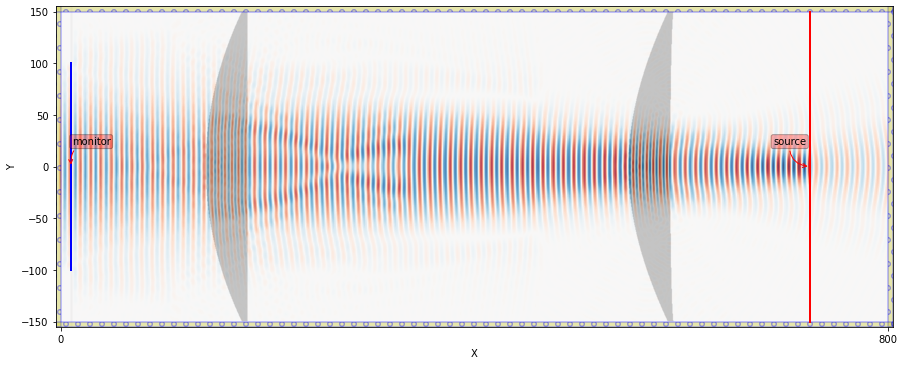

In [26]:
analysis.sim.plot_efield()

(Note : if the plot isn't displayed, run the line %matplolib inline again)

We can now plot the far field beam.

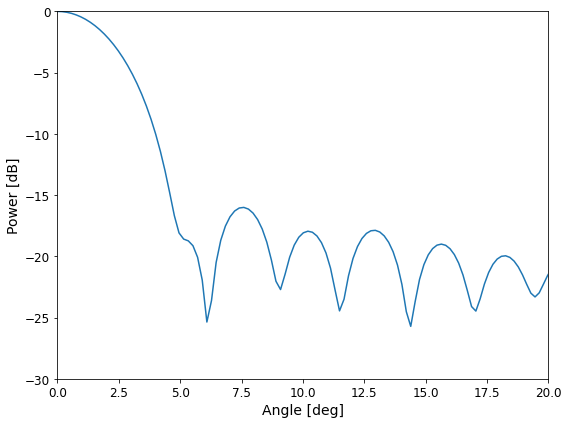

In [28]:
analysis.plotting(freq, beam, wavelength, ylim = -30)

We can add some information to the plot, like the beam solid angle and the best fit gaussian full width at half maximum.

Beam n.0 solid angle : 6.856e-01 srads
Best fit Gaussian FWHM : 4.66deg
Theoretical FWHM : 2.86deg


/home/alexei/MEEP/MEEP_optics/meep_optics.py:1812: RuntimeWarning: divide by zero encountered in log10
  y = 10*np.log10(gaussian(deg, popt[0], popt[1]))


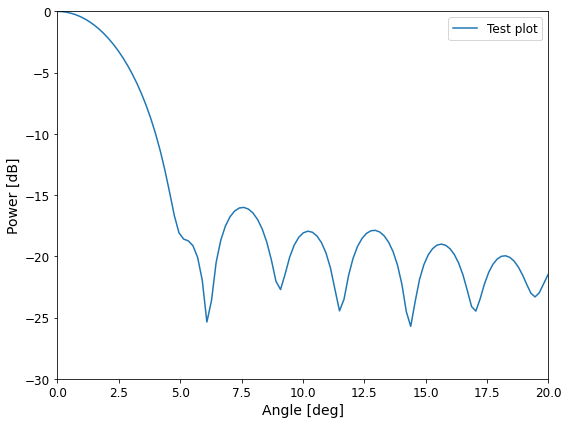

In [31]:
analysis.plotting(freq, beam, wavelength, ylim=-30, legend = ['Test plot'], print_solid_angle = True, print_fwhm = True)

It is possible to obtain the far field beam for a different sources with different properties, which are wavelength, position on image plane and beam waist. Let's look at different sources at the same time.

-----------
Initializing structure...
read in 1621x621x1 epsilon-input-file "epsilon_map.h5:eps"
time for choose_chunkdivision = 0.000308037 s
Working in 2D dimensions.
Computational cell is 810 x 310 x 0 with resolution 2
     block, center = (-390,127.5,0)
          size (2,55,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (-390,-127.5,0)
          size (2,55,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (324.704,0,0)
          size (2,300,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
time for set_epsilon = 1.60655 s
time for set_conductivity = 0.061743 s
time for set_conductivity = 0.0611222 s
time for set_conductivity = 0.0619161 s
-----------
Meep progress: 131.5/800.0 = 16.4% done in 4.0s, 20.4s to go
on time step 526 (time=131.5), 0.00761615 s/step
M

Meep progress: 364.75/800.0 = 45.6% done in 12.0s, 14.3s to go
on time step 1459 (time=364.75), 0.00876584 s/step
Meep progress: 475.75/800.0 = 59.5% done in 16.0s, 10.9s to go
on time step 1903 (time=475.75), 0.009027 s/step
Meep progress: 594.5/800.0 = 74.3% done in 20.0s, 6.9s to go
on time step 2378 (time=594.5), 0.00843364 s/step
Meep progress: 720.75/800.0 = 90.1% done in 24.0s, 2.6s to go
on time step 2883 (time=720.75), 0.00792864 s/step
run 0 finished at t = 800.0 (3200 timesteps)
on time step 3200 (time=800), 0.0176628 s/step
run 1 finished at t = 800.5 (3202 timesteps)
run 2 finished at t = 801.0 (3204 timesteps)
run 3 finished at t = 801.5 (3206 timesteps)
run 4 finished at t = 802.0 (3208 timesteps)
run 5 finished at t = 802.5 (3210 timesteps)
run 6 finished at t = 803.0 (3212 timesteps)
run 7 finished at t = 803.5 (3214 timesteps)
run 8 finished at t = 804.0 (3216 timesteps)
run 9 finished at t = 804.5 (3218 timesteps)
run 10 finished at t = 805.0 (3220 timesteps)
run 11 

run 12 finished at t = 806.0 (3224 timesteps)
run 13 finished at t = 806.5 (3226 timesteps)
run 14 finished at t = 807.0 (3228 timesteps)
run 15 finished at t = 807.5 (3230 timesteps)
run 16 finished at t = 808.0 (3232 timesteps)
run 17 finished at t = 808.5 (3234 timesteps)
run 18 finished at t = 809.0 (3236 timesteps)
run 19 finished at t = 809.5 (3238 timesteps)
run 20 finished at t = 810.0 (3240 timesteps)
run 21 finished at t = 810.5 (3242 timesteps)
run 22 finished at t = 811.0 (3244 timesteps)
run 23 finished at t = 811.5 (3246 timesteps)
run 24 finished at t = 812.0 (3248 timesteps)
run 25 finished at t = 812.5 (3250 timesteps)
run 26 finished at t = 813.0 (3252 timesteps)
run 27 finished at t = 813.5 (3254 timesteps)
run 28 finished at t = 814.0 (3256 timesteps)
run 29 finished at t = 814.5 (3258 timesteps)
run 30 finished at t = 815.0 (3260 timesteps)
run 31 finished at t = 815.5 (3262 timesteps)
run 32 finished at t = 816.0 (3264 timesteps)
run 33 finished at t = 816.5 (3266

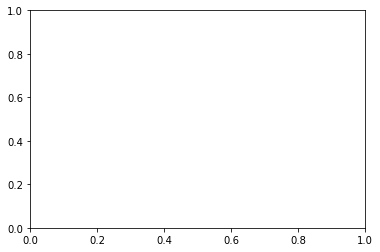

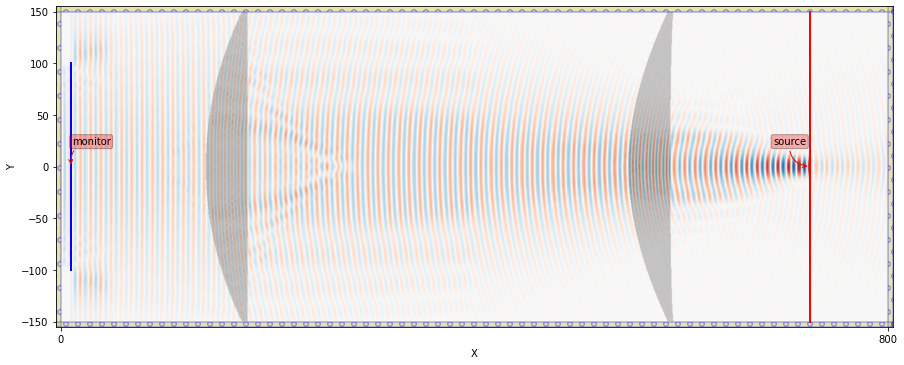

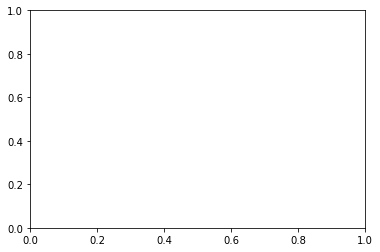

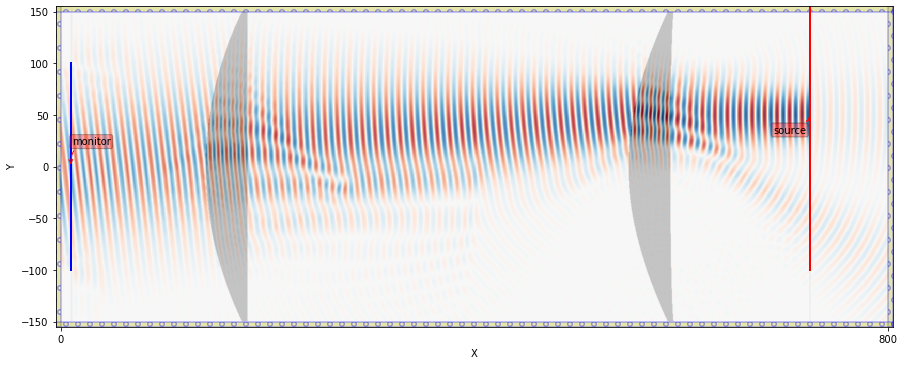

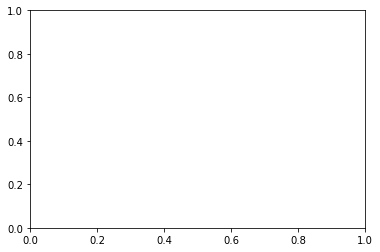

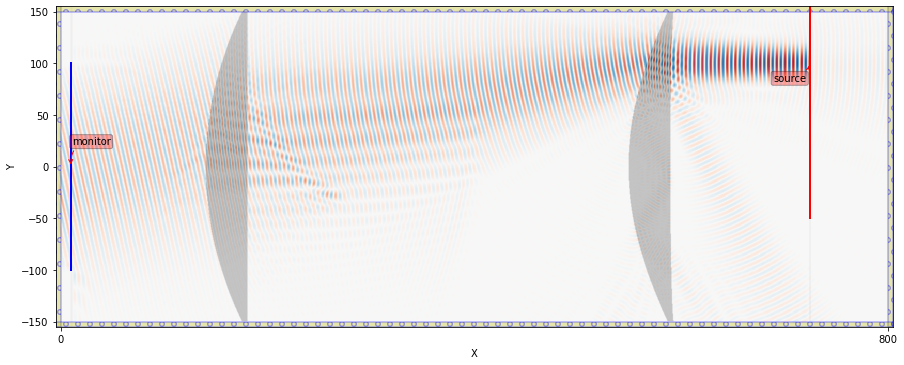

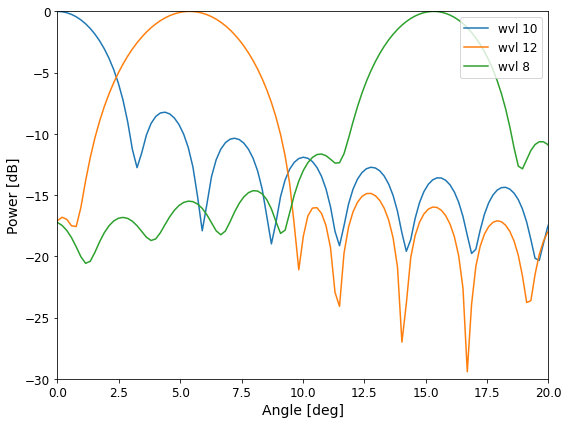

In [34]:
analysis.image_plane_beams(wvl = [10, 12, 8],
                           simres = 2, 
                           runtime = 800,
                           y_source = [0., 50, 100.],
                           beam_w0 = [10, 24, 15])

freq, beam = analysis.beam_FT()
analysis.plotting(freq, beam, wavelength, ylim = -30, legend = ['wvl 10', 'wvl 12', 'wvl 8'])

Note that a full simulation is required for each beam, which makes the execution take a long time. This is why it is intersting to put y_max to be the edge of the image plane and N_beams = 2 to obtain only the two extreme situations, beam on axis and beam as far off axis as can be.